In [1]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import hdbscan

In [2]:
# Read the JSON data from the file
with open('tagged_data.json') as file:
    data = json.load(file)

# Create a DataFrame from the JSON data
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Visualize the tags using value_counts()
tag_counts = df['tags'].explode().value_counts()
print("\nTag Counts:")
print(tag_counts)

                                                 name  \
0                                            get help   
1                                   customize firefox   
2                                        get involved   
3                                            about us   
4                                     getting started   
5                                                       
6                                                       
7                                                       
8       machining fabrication services  manufacturing   
9   barrons essential words for the gre at duckduckgo   
10                                                ets   
11                    best paper digest  paper digest   
12  peco perceptual codebook for bert pretraining ...   
13                   how is recursion used in pytorch   
14                              the gflownet tutorial   
15   managed it  cybersecurity for financial services   
16  cyber security training deg

/home/tim/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Cluster 0:
  - get help (https://support.mozilla.org/products/firefox)
  - get involved (https://www.mozilla.org/contribute/)

Cluster 1:
  - customize firefox (https://support.mozilla.org/kb/customize-firefox-controls-buttons-and-toolbars?utm_source=firefox-browser&utm_medium=default-bookmarks&utm_campaign=customize)
  - getting started (https://www.mozilla.org/firefox/?utm_medium=firefox-desktop&utm_source=bookmarks-toolbar&utm_campaign=new-users&utm_content=-global)

Cluster 30:
  - about us (https://www.mozilla.org/about/)

Cluster 32:
  -  (https://claude.ai/chats)

Cluster 17:
  -  (https://www.perplexity.ai/)

Cluster 20:
  -  (https://us-east-2.console.aws.amazon.com/console/home?nc2=h_ct&region=us-east-2&src=header-signin#)

Cluster 24:
  - machining fabrication services  manufacturing (https://marmeninc.com/en)

Cluster 31:
  - barrons essential words for the gre at duckduckgo (https://duckduckgo.com/?q=Barron%27s+Essential+Words+for+the+GRE&t=newext&atb=v415-1&ia=web)

Clust

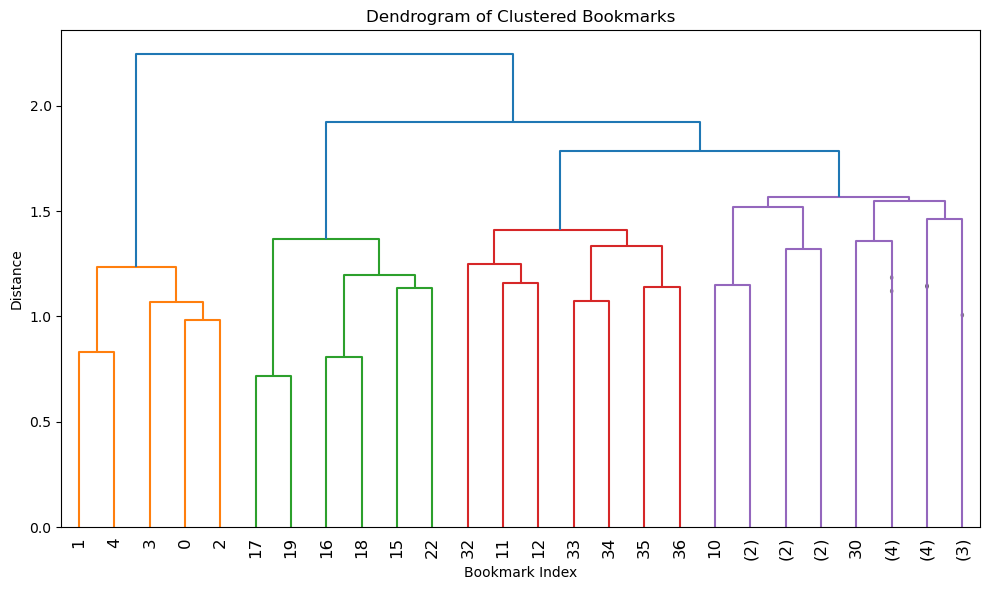

In [8]:
import json
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sentence_transformers import SentenceTransformer
import os
from transformers import BertTokenizer, TFBertModel, BertModel
import matplotlib.pyplot as plt

# Disable parallel tokenization to avoid multiprocessing issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def load_model(model_name):
    try:
        return SentenceTransformer(model_name)
    except Exception as e:
        raise RuntimeError(f"Error loading model: {e}")

def validate_bookmarks(bookmarks):
    if not bookmarks:
        raise ValueError("No bookmarks provided.")
    if not isinstance(bookmarks, list) or not all(isinstance(item, dict) for item in bookmarks):
        raise ValueError(f"Incorrect bookmarks format: {bookmarks}")

def encode_texts(model, texts):
    try:
        return model.encode(texts)
    except Exception as e:
        raise RuntimeError(f"Error encoding texts: {e}")

def perform_clustering(embeddings, distance_threshold=1.0):
    try:
        link_matrix = linkage(embeddings, method='ward')
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, compute_full_tree=True)
        clusters = clustering.fit_predict(embeddings)
        return clusters, link_matrix
    except Exception as e:
        raise RuntimeError(f"Error during clustering: {e}")

def cluster_texts(bookmarks):
    validate_bookmarks(bookmarks)
    model = load_model('all-MiniLM-L6-v2')
    texts = [f"{bookmark['name']} {bookmark['url']}" for bookmark in bookmarks]
    embeddings = encode_texts(model, texts)
    clusters, link_matrix = perform_clustering(embeddings)
    return clusters, len(set(clusters)), embeddings, link_matrix

# Read the JSON data from the file
with open('tagged_data.json') as file:
    data = json.load(file)

# Perform initial clustering
clusters, num_clusters, embeddings, link_matrix = cluster_texts(data)

# Create a dictionary to store the clusters and their bookmarks
cluster_dict = {}
for i, cluster_label in enumerate(clusters):
    if cluster_label not in cluster_dict:
        cluster_dict[cluster_label] = []
    cluster_dict[cluster_label].append(data[i])

def update_clusters(distance_threshold):
    clusters, link_matrix = perform_clustering(embeddings, distance_threshold)
    num_clusters = len(set(clusters))

    cluster_dict = {}
    for i, cluster_label in enumerate(clusters):
        if cluster_label not in cluster_dict:
            cluster_dict[cluster_label] = []
        cluster_dict[cluster_label].append(data[i])

    plt.figure(figsize=(10, 6))
    dendrogram(link_matrix, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=12, show_contracted=True)
    plt.title(f'Dendrogram of Clustered Bookmarks (Threshold: {distance_threshold:.2f})')
    plt.xlabel('Bookmark Index')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

    print(f"Total number of clusters: {num_clusters}")
    for cluster_label, bookmarks in cluster_dict.items():
        print(f"Cluster {cluster_label}:")
        for bookmark in bookmarks:
            print(f"  - {bookmark['name']} ({bookmark['url']})")
        print()

# Create an interactive slider for distance_threshold
distance_threshold_slider = FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0, description='Distance Threshold')

# Use the interact function to update clusters based on the slider value
interact(update_clusters, distance_threshold=distance_threshold_slider)